# Khomkin Konstantin, cohort 53DS
Complex Project-2, v.1.0 27.12.2022

# Introduction
The goal of the project is to train a model that will help to predict the efficiency of the processes at different stages of gold ore beneficiation by observational data. For this purpose, the project will accomplish the following tasks:
1. initial data are investigated
2. Using direct mathematical calculations, the accuracy of the efficiency calculations is verified
3. The data is put into a form suitable for machine learning
4. The best learning model is selected by cross-validation method, using the sMAPE metric.
5. The selected model is validated on a test sample and checked for adequacy.


## Step 1. Import the necessary libraries, open and study the structure of the available files. Prepare data


**Technological Process**
<br>Rougher feed — raw material
<br>Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
<br>Xanthate ** — xanthate (promoter or flotation activator);
<br>Sulphate — sulfate (sodium sulfide at this plant);
<br>Depressant — depressant (sodium silicate).
<br>Rougher process — flotation
<br>Rougher tails — tailings
<br>Float banks — flotation unit
<br>Cleaner process — cleaning
<br>Rougher Au — rough gold concentrate
<br>Final Au — final gold concentrate
<br><br>**Stage Parameters**
<br>air amount — air volume
<br>fluid levels — liquid level
<br>feed size — raw material particle size
<br>feed rate — feeding rate
<br><br>**Possible Values for [Stage] Block:**
<br>rougher — flotation
<br>primary_cleaner — primary cleaning
<br>secondary_cleaner — secondary cleaning
<br>final — final characteristics
<br><br>**Possible Values for [Parameter_Type] Block:**
<br>input — input parameters
<br>output — output parameters
<br>state — parameters describing the current stage state
<br>calculation — calculated characteristics

In [2]:
import pandas as pd # Pandas library is needed for working with the dataset

from sklearn.metrics import mean_absolute_error # Method for calculating Mean Absolute Error (MAE)

from matplotlib import pyplot as plt # Library for creating plots

import numpy as np # Numpy library is needed for mathematical functions (sum, absolute value, etc.)

from sklearn.tree import DecisionTreeRegressor # "Decision Tree" model

from sklearn.linear_model import LinearRegression # "Linear Regression" model

from sklearn.ensemble import RandomForestRegressor # "Random Forest" model

from sklearn.model_selection import cross_val_score # Function for model evaluation using cross-validation

from sklearn.metrics import make_scorer # Method for creating a scoring method for cross-validation

from sklearn.preprocessing import StandardScaler # Method for data scaling

from sklearn.dummy import DummyRegressor # Constant model for adequacy testing


### 1.1. Откроем и изучим файлы

In [3]:
# Import data into three separate datasets
df_train = pd.read_csv('gold_recovery_train_new.csv')
df_test = pd.read_csv('gold_recovery_test_new.csv')
df_full = pd.read_csv('gold_recovery_full_new.csv')

In [4]:
# Let's look at the size of the datasets
df_train.shape, df_test.shape, df_full.shape


((14149, 87), (5290, 53), (19439, 87))

In [5]:
# See how the data is organized and formatted. Let's display information on the most complete file
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
date                                                  19439 non-null object
final.output.concentrate_ag                           19438 non-null float64
final.output.concentrate_pb                           19438 non-null float64
final.output.concentrate_sol                          19228 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19438 non-null float64
final.output.tail_pb                                  19338 non-null float64
final.output.tail_sol                                 19433 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19415 non-null float64
primary_cleaner.input.depressant             

In [6]:
# There is a column with date in the data, but the data type is object. It is better to store the date in a variable with the datetype type

# To convert to a new format, we need to see what the data looks like in order to make a rule for converting to datatype format.

print(df_train['date'].head(5))
print(df_test['date'].head(5))
print(df_full['date'].head(5))


0    2016-01-15 00:00:00
1    2016-01-15 01:00:00
2    2016-01-15 02:00:00
3    2016-01-15 03:00:00
4    2016-01-15 04:00:00
Name: date, dtype: object
0    2016-09-01 00:59:59
1    2016-09-01 01:59:59
2    2016-09-01 02:59:59
3    2016-09-01 03:59:59
4    2016-09-01 04:59:59
Name: date, dtype: object
0    2016-01-15 00:00:00
1    2016-01-15 01:00:00
2    2016-01-15 02:00:00
3    2016-01-15 03:00:00
4    2016-01-15 04:00:00
Name: date, dtype: object


In [7]:
# Looking at the date format, let's make a translation rule

df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')

In [8]:
# Check the result

print(df_train['date'].head(5))
print(df_test['date'].head(5))
print(df_full['date'].head(5))

0   2016-01-15 00:00:00
1   2016-01-15 01:00:00
2   2016-01-15 02:00:00
3   2016-01-15 03:00:00
4   2016-01-15 04:00:00
Name: date, dtype: datetime64[ns]
0   2016-09-01 00:59:59
1   2016-09-01 01:59:59
2   2016-09-01 02:59:59
3   2016-09-01 03:59:59
4   2016-09-01 04:59:59
Name: date, dtype: datetime64[ns]
0   2016-01-15 00:00:00
1   2016-01-15 01:00:00
2   2016-01-15 02:00:00
3   2016-01-15 03:00:00
4   2016-01-15 04:00:00
Name: date, dtype: datetime64[ns]


Summary: Dataset sizes are different. There are gaps in the data. The good news is that there is nothing wrong with the data types.

### 1.2. Let's check that the enrichment efficiency is calculated correctly
Calculate the enrichment efficiency on the training sample for trait **ougher.output.recovery**
Let's find the average MAE error between the calculation and the trait value. 



In [9]:
# For convenience/laconicality, let's keep the initial data in variables and check completeness

# C - gold fraction in concentrate after flotation/treatment;
# F - gold fraction in feed/concentrate before flotation/treatment;
# T - gold fraction in tailings after flotation/treatment.


c = df_train['rougher.output.concentrate_au']
f = df_train['rougher.input.feed_au']
t = df_train['rougher.output.tail_au']

c.shape, f.shape, t.shape

((14149,), (14149,), (14149,))

In [10]:
# Enrichment efficiency at the "Flotation" stage according to known data
recovery_true = df_train['rougher.output.recovery']

# Enrichment efficiency, calculated by function:
recovery_calc = ((c*(f-t))/(f*(c-t))) * 100



In [11]:
# Similarly check if all rows have enough data
recovery_true.shape, recovery_calc.shape

((14149,), (14149,))

In [12]:
# Check if there are no errors in the calculations (there is a division operator in the function, possibly division by zero)

print(recovery_true.isna().sum()) 
print(recovery_calc.isna().sum()) 


0
0


In [13]:
# Calculate the MAE by applying a function from the sklearn library. mean_absolute_error(recovery_true, recovery_calc)

9.682896147825551e-15

**Intermediate conclusion** The mean error value is 9.7e-15, which is very small. We consider that the calculations are correct.

### 1.3. Let's analyze the features unavailable in the test sample.

In [14]:
# In order to identify features that are not available in the test sample, we need to compare the lists of 
# column names of our datasets, namely, look at the difference between the lists of columns of train and test samples


# "Head-on" construction df_train.columns - df_test.columns leads to the error
# "operands could not be broadcast together with shapes (53,) (87,)"
# so let's use the set() function to form sets between which the compare/subtract operations etc. will be applied.

set(df_train.columns) - set(df_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

The attributes unavailable in the test sample are data on product parameters at the output of the processes (...output...), as well as 4 calculated parameters at the output of the Flotation process (rougher.calculation....).

Importantly, there are no attributes in the test sample that are targeted for our problem. To check the model metrics, these columns should be added using the merge method, the index will be the date column (according to the conditions, the data are indexed by date and time)


In [15]:
df_test = df_test.merge(df_full.loc[:, ['date','rougher.output.recovery','final.output.recovery']], on='date')


### 1.4. Let's preprocess the data
Earlier we saw by applying .info() that there are gaps in the data, let's examine them further

In [16]:
print(df_train.shape)
print(df_train.isna().sum().sort_values(ascending=False))

(14149, 87)
secondary_cleaner.output.tail_sol             1605
rougher.state.floatbank10_e_air                436
rougher.input.floatbank11_xanthate             428
primary_cleaner.output.concentrate_sol         286
secondary_cleaner.state.floatbank2_a_air       217
final.output.concentrate_sol                   211
rougher.input.feed_size                        144
final.output.tail_pb                           100
rougher.input.feed_pb                          100
primary_cleaner.input.xanthate                 100
primary_cleaner.output.concentrate_pb           86
rougher.input.feed_sol                          78
primary_cleaner.output.tail_sol                 46
rougher.input.floatbank11_sulfate               36
primary_cleaner.input.depressant                32
rougher.input.floatbank10_sulfate               29
rougher.output.concentrate_sol                  22
secondary_cleaner.state.floatbank2_b_air        21
primary_cleaner.input.sulfate                   20
primary_cleaner.out

In [17]:
print(df_test.shape)
print(df_test.isna().sum().sort_values(ascending=False))   

(5290, 55)
rougher.input.floatbank11_xanthate            25
rougher.input.feed_sol                        21
secondary_cleaner.state.floatbank3_a_air       9
rougher.input.floatbank11_sulfate              8
primary_cleaner.input.depressant               5
rougher.input.floatbank10_sulfate              5
primary_cleaner.input.sulfate                  4
primary_cleaner.input.xanthate                 4
secondary_cleaner.state.floatbank2_a_air       3
rougher.input.feed_rate                        3
secondary_cleaner.state.floatbank2_b_air       2
rougher.input.feed_size                        1
final.output.recovery                          0
rougher.state.floatbank10_a_air                0
rougher.input.floatbank10_xanthate             0
rougher.input.feed_au                          0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.state.floatbank10_b_air                0
primary_cleaner.state.floatbank8_d_level       0
primary_c

Gaps analysis showed that in the test sample the gaps are insignificant (less than 5% in the "bad" column), and in the training sample only in the values of one parameter there is a noticeable (more than 10%) number of gaps (secondary_cleaner.output.tail_sol)

According to the data description "Neighboring parameters are often similar in time", so the data should not have outliers and are rather unbroken, accordingly it is acceptable to fill the gaps using linear interpolation (pandas.DataFrame.interpolate).

In [18]:
# Apply linear interpolation to the training sample

df_train = df_train.interpolate()
# print(df_train.isna().sum().sort_values(ascending=False))

In [19]:
# Check for duplicates
df_train.duplicated().sum(), df_test.duplicated().sum(), df_full.duplicated().sum()

(0, 0, 0)

In [20]:
# For further analysis and training of the model it makes sense to remove the data column, for training it will be rather harmful

df_train = df_train.drop('date', axis=1)
df_test = df_test.drop('date', axis=1)
df_full = df_full.drop('date', axis=1)

### Step 2: Analyze the data
### 2.1. Let's see how the concentration of metals (Au, Ag, Pb) changes during different purification steps


rougher.input.feed_au      8.266097326589135
rougher.output.concentrate_au      19.772000139486334
primary_cleaner.output.concentrate_au      32.1194004078766
final.output.concentrate_au      44.076512941952664


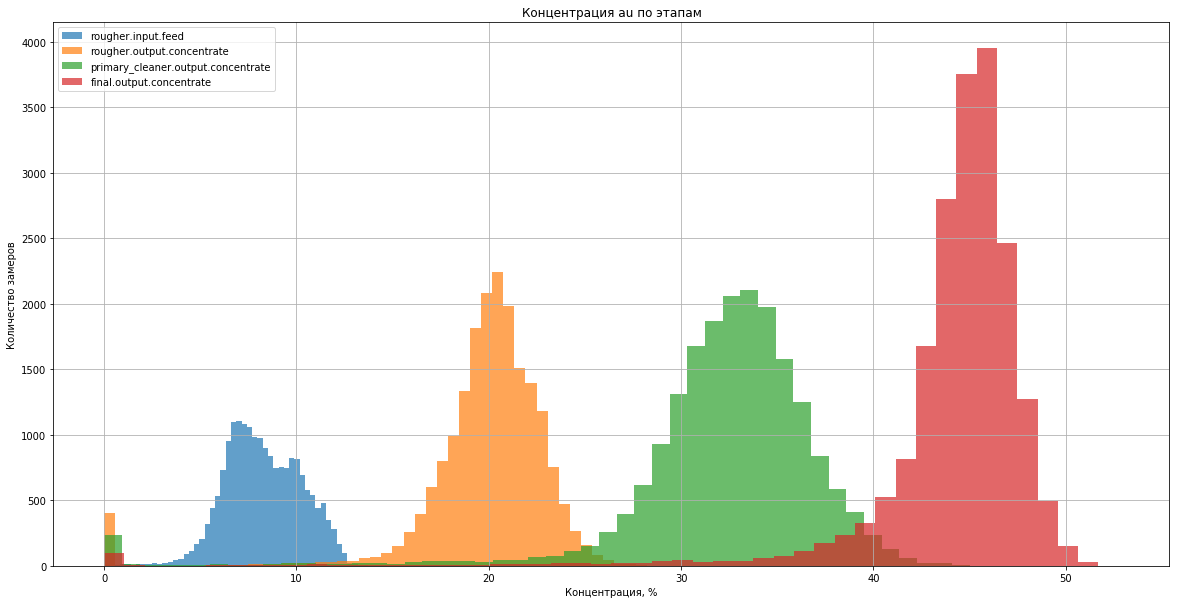

rougher.input.feed_ag      8.7949274258147
rougher.output.concentrate_ag      11.994759359873452
primary_cleaner.output.concentrate_ag      8.442408077719056
final.output.concentrate_ag      5.168470373676826


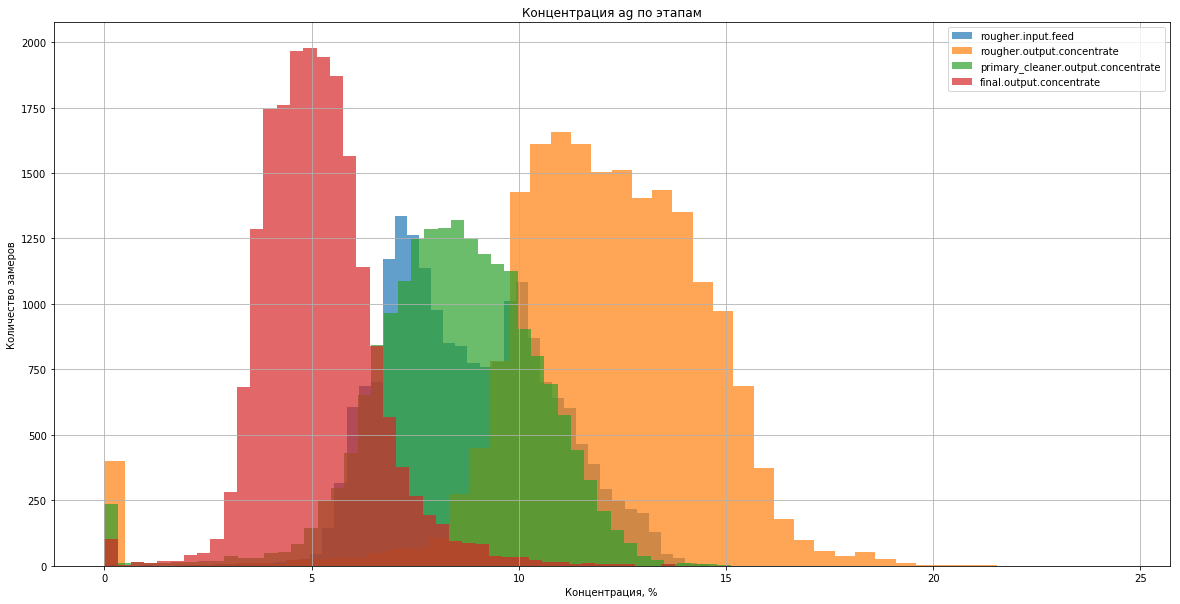

rougher.input.feed_pb      3.598084975395446
rougher.output.concentrate_pb      7.606272313194984
primary_cleaner.output.concentrate_pb      9.829529774200587
final.output.concentrate_pb      9.978894911181714


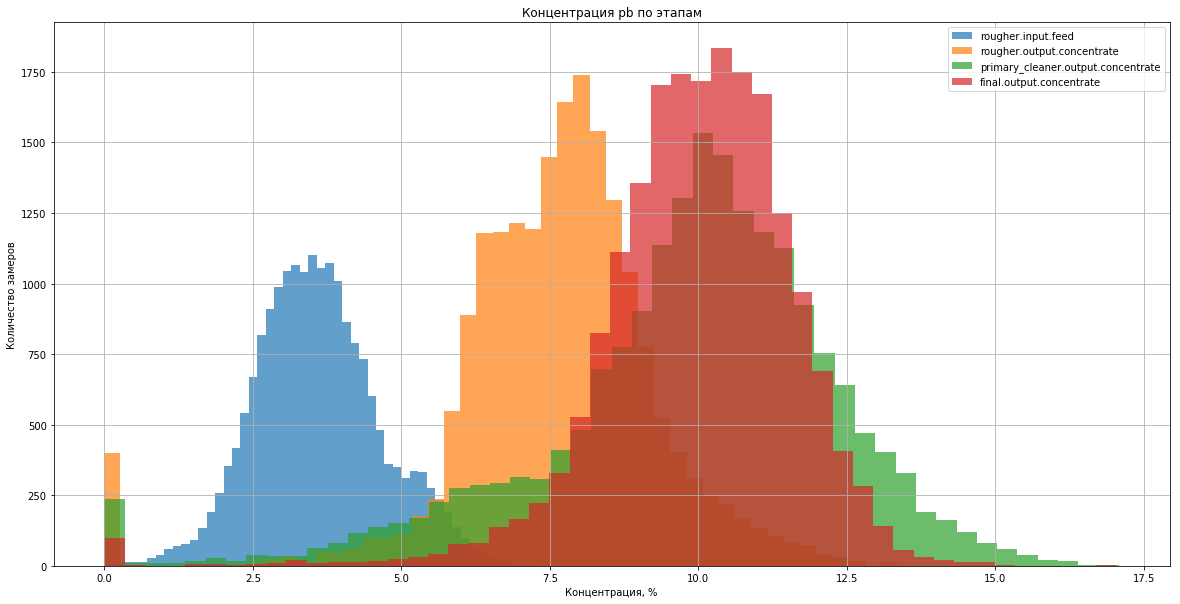

In [21]:
# To avoid confusion in the columns, we will collect parts of the column name blocks in separate constants. p

# We will analyze concentrations only in the so-called "concentrate", i.e. in the "useful" substance flow. 
# In the "tails" (i.e. in the waste from each step), the component composition is not so interesting


# In the data we have 

# 1 Composition of the input 
# rougher.input.feed_ag
# rougher.input.feed_pb
# rougher.input.feed_au

# 2 Composition of the concentrate at the output of the flotation process
# rougher.output.concentrate_ag                         
# rougher.output.concentrate_pb                         
# rougher.output.concentrate_au                         

# 3 Composition of concentrate at the output of the primary cleaning process
# primary_cleaner.output.concentrate_ag                 
# primary_cleaner.output.concentrate_pb                
# primary_cleaner.output.concentrate_au                

# 4 Composition of the concentrate at the output of the secondary enrichment process
# final.output.concentrate_ag                           
# final.output.concentrate_pb                           
# final.output.concentrate_au                           

# STAGE constant to which we add the names of the processing steps
# rougher - flotation
# primary_cleaner - primary cleaning
# final - composition after secondary cleaning


STAGE = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']


# COMPONENT constant, in which we will store the names of the components
# au - Aurum, gold
# pb - Plumbum, lead
# ag - Argentum, silver
# sol - Solutio, which is the usual chemical term for a solvent without specifying its composition. 
# Solvent content will not be plotted on the graph

COMPONENT = ['au', 'ag', 'pb']

for metall in COMPONENT:
    
    plt.figure(figsize=(20,10))
    
    plt.title(f'Концентрация {str(metall)} по этапам')

    for step in STAGE:
        df_full[f'{step}_{metall}'].hist(bins=50, label=step, alpha=0.7)
        plt.legend()
        plt.xlabel('Концентрация, %')
        plt.ylabel('Количество замеров')
        print(f'{step}_{metall}     ', df_full[f'{step}_{metall}'].mean())

    plt.show()




**Conclusion:** The concentration of gold increases through the purification stages, silver also increases at first, then decreases finally, lead increases slightly and then does not change.
Gold content increases from 8% to 44%

### 2.2. Distribution of raw material granule sizes on training and test samples.

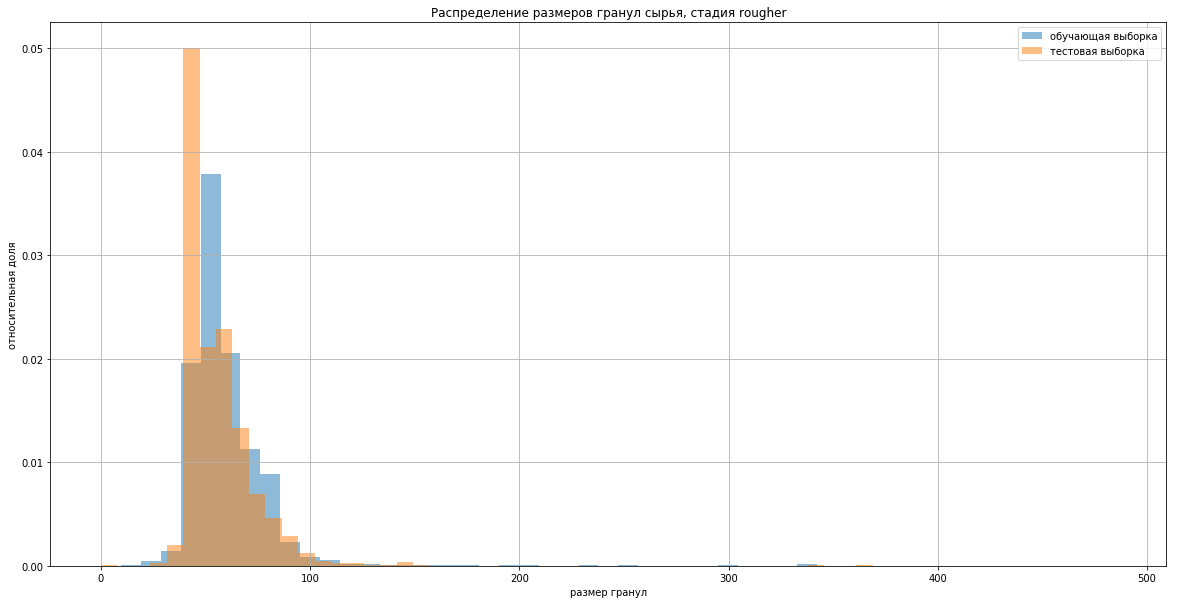

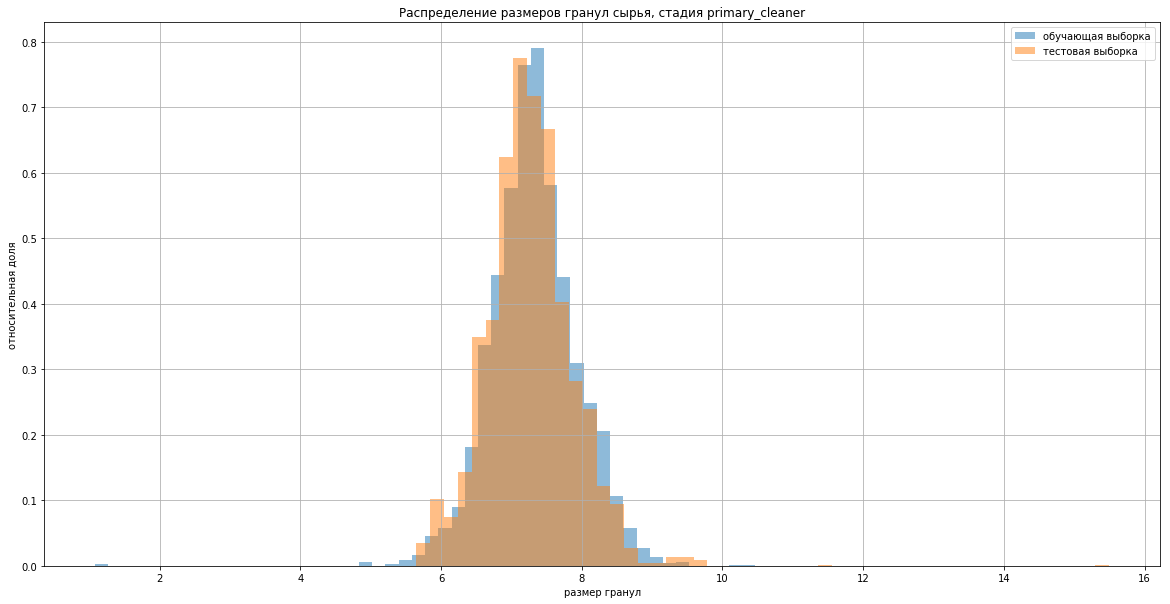

In [32]:
# pellet size is stored in columns rougher.input.feed_size and primary_cleaner.input.feed_size
# compare the size distributions of the training and test samples

for step in ['rougher', 'primary_cleaner']:

    plt.figure(figsize=(20,10))
    
    plt.title(f'Распределение размеров гранул сырья, стадия {step}')
          
    df_train[f'{step}.input.feed_size'].hist(bins=50, density=True, label='обучающая выборка', alpha=0.5)
    df_test[f'{step}.input.feed_size'].hist(bins=50, density=True, label='тестовая выборка', alpha=0.5)

    plt.legend()
    plt.xlabel('размер гранул')
#   plt.ylabel('Количество замеров')
    plt.ylabel('относительная доля')

    plt.show()


In [33]:
# In general, the histograms look similar, the difference is in the number of observations, which should not affect the quality of the model.
# Let's also look at the description of the distributions:

# print(df_train['rougher.input.feed_size'].describe())
# print(df_test['rougher.input.feed_size'].describe())


for step in ['rougher', 'primary_cleaner']:
         
    print('Обучающая выборка:')
    print(df_train[f'{step}.input.feed_size'].describe())
    print('Тестовая выборка:')
    print(df_test[f'{step}.input.feed_size'].describe())
    print()

Обучающая выборка:
count    13725.000000
mean        60.170758
std         23.137250
min          9.659576
25%         48.982458
50%         55.392467
75%         66.034792
max        484.967466
Name: rougher.input.feed_size, dtype: float64
Тестовая выборка:
count    5289.000000
mean       55.951097
std        19.081758
min         0.046369
25%        43.906347
50%        50.841029
75%        62.431047
max       392.494040
Name: rougher.input.feed_size, dtype: float64

Обучающая выборка:
count    13725.000000
mean         7.324104
std          0.616810
min          1.080000
25%          6.960000
50%          7.300000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64
Тестовая выборка:
count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64



**Conclusion:** The distributions of particle size data in the training and test samples are similar and do not interfere with model training and estimation


### 2.3. Study the total concentrations of all substances at different stages: in the raw material, in the rough and final concentrates 

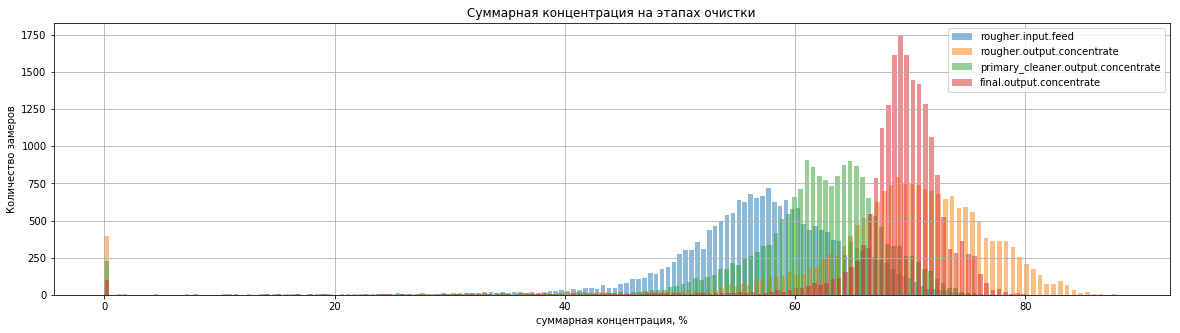

In [34]:
#STAGE = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']


# The COMPONENT_FULL constant, where we'll store the names of all the component substances.
# au - Aurum, gold
# pb - Plumbum, lead
# ag - Argentum, silver
# sol - Solutio, this is how solvent is usually denoted in chemistry without specifying its composition. 


COMPONENT_FULL = ['au', 'ag', 'pb', 'sol']

# The total concentrations will be added to a new dataset, into which we will first copy the data from the full dataset.

df_sum = df_full

plt.figure(figsize=(20,5))
plt.title(f'Суммарная концентрация на этапах очистки')

for step in STAGE:
    df_sum[f'{step}_sum'] = 0 

    for substance in COMPONENT_FULL:
        df_sum[f'{step}_sum'] += df_sum[f'{step}_{substance}']
    
    df_sum[f'{step}_sum'].hist(bins=150, label=step, width=0.4, alpha=0.5)

plt.legend()
plt.xlabel('суммарная концентрация, %')
plt.ylabel('Количество замеров')
plt.show()        
    
    


**Final:** We see normal distributions of the total concentration, and at the final stage of purification the distribution is more "sharp" and pronounced, indicating that there is less scatter of values relative to the mean. 

The presence of outliers at zero values is highlighted. Total concentrations should not be zero. There may have been zeros in the individual component concentration data, but if zeros remain in the total concentrations as well, it is erroneous data. These outliers can negatively affect model training in further steps. Let's remove them.

In [35]:
for step in STAGE:

    df_train = df_train[(df_train[f'{step}_au'] != 0) & 
                        (df_train[f'{step}_ag'] != 0) & 
                        (df_train[f'{step}_pb'] != 0) & 
                        (df_train[f'{step}_sol'] != 0)]

In [36]:
df_train.shape

(13725, 86)

Before building the model, it is necessary to understand the correlations within the dataset. 
There is a lot of data and it is very likely that some columns are highly correlated. It is difficult to study the 87x87 matrix manually and "by eye", let's try to algorithmize and find the maximum correlations between individual features. 

In [37]:
# Declare an auxiliary function that returns an array of "extra" (repeated) combinations of pairs of all dataset columns 
def get_pairs(df):
    pairs = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs.add((cols[i], cols[j]))
    return pairs

# Declare a function that will calculate all correlations and return the specified number of maximal module values without taking into account repetitions
def get_top_abs_correlations(df, n=5):
    corr = df.corr().abs().unstack()
    col_to_drop = get_pairs(df)
    corr = corr.drop(labels=col_to_drop).sort_values(ascending=False)
    return corr[0:n]

print('Самые высокие показатели модуля корреляции в датасете:')
print(get_top_abs_correlations(df_full, 10))

Самые высокие показатели модуля корреляции в датасете:
rougher.state.floatbank10_b_level                   rougher.state.floatbank10_c_level                     0.987836
rougher.state.floatbank10_e_level                   rougher.state.floatbank10_f_level                     0.980917
rougher.state.floatbank10_c_level                   rougher.state.floatbank10_d_level                     0.980911
rougher.state.floatbank10_b_level                   rougher.state.floatbank10_d_level                     0.971205
rougher.output.concentrate_sol                      rougher.output.concentrate_sum                        0.970909
rougher.calculation.floatbank10_sulfate_to_au_feed  rougher.calculation.floatbank11_sulfate_to_au_feed    0.965838
rougher.state.floatbank10_c_level                   rougher.state.floatbank10_e_level                     0.962115
primary_cleaner.state.floatbank8_a_air              primary_cleaner.state.floatbank8_b_air                0.953129
rougher.state.floatbank10

The hypothesis of high correlations turned out to be correct. To avoid multicollinearity, "extra" columns should be removed.  

First, we remove from the training sample those columns that are absent in the test sample (except for the two target traits that were added in step 1.2).

In [38]:
# array of "extra" column names
col_to_drop = set(df_train.columns) - set(df_test.columns)

In [39]:
# remove "extra" columns from the training sample
df_train = df_train.drop(columns=col_to_drop, axis=1)

In [40]:
# control the dimension
df_train.shape, df_test.shape

((13725, 54), (5290, 54))

In [41]:
# now check the training sample for multicollinearity and extract the names of columns with correlation above 0.7


list_corr = pd.DataFrame(get_top_abs_correlations(df_train, 100))

# gets rid of the multi-index
list_corr = list_corr.reset_index()

In [42]:
# and rename the columns for convenience
list_corr.columns = ['label_1', 'label_2', 'cor']

In [43]:
# make a list of columns that have a correlation with any other column above 0.7
high_corr_cols = list_corr['label_2'][list_corr['cor'] > 0.7]

In [44]:
high_corr_cols

0              rougher.state.floatbank10_f_level
1              rougher.state.floatbank10_c_level
2              rougher.state.floatbank10_d_level
3              rougher.state.floatbank10_e_level
4       primary_cleaner.state.floatbank8_b_level
5              rougher.state.floatbank10_d_level
6              rougher.state.floatbank10_f_level
7              rougher.state.floatbank10_e_level
8              rougher.state.floatbank10_f_level
9              rougher.state.floatbank10_e_level
10      primary_cleaner.state.floatbank8_c_level
11             rougher.state.floatbank10_f_level
12      primary_cleaner.state.floatbank8_c_level
13        primary_cleaner.state.floatbank8_b_air
14        primary_cleaner.state.floatbank8_c_air
15               rougher.state.floatbank10_c_air
16        primary_cleaner.state.floatbank8_c_air
17               rougher.state.floatbank10_d_air
18               rougher.state.floatbank10_f_air
19               rougher.state.floatbank10_d_air
20    secondary_clea

In [45]:
# get rid of repetitions, leaving only unique values for later deletion
high_corr_cols_list = set(high_corr_cols.unique())


In [46]:
# remove columns that lead to multicollinearity
df_train = df_train.drop(columns=high_corr_cols_list, axis=1)

In [47]:
# check again the training sample.
print('Самые высокие показатели модуля корреляции в датасете:')
print(get_top_abs_correlations(df_train, 100))

Самые высокие показатели модуля корреляции в датасете:
secondary_cleaner.state.floatbank3_a_air    secondary_cleaner.state.floatbank3_b_air      0.685915
                                            secondary_cleaner.state.floatbank4_a_air      0.682191
secondary_cleaner.state.floatbank3_a_level  secondary_cleaner.state.floatbank3_b_level    0.652549
rougher.state.floatbank10_a_level           secondary_cleaner.state.floatbank4_a_air      0.618726
final.output.recovery                       rougher.output.recovery                       0.614190
rougher.input.feed_rate                     rougher.input.floatbank10_xanthate            0.587954
rougher.state.floatbank10_a_air             rougher.state.floatbank10_a_level             0.575338
primary_cleaner.input.sulfate               rougher.input.feed_pb                         0.572079
rougher.state.floatbank10_a_air             secondary_cleaner.state.floatbank4_a_air      0.564975
rougher.input.feed_rate                     rougher.in

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13725 entries, 0 to 14148
Data columns (total 29 columns):
final.output.recovery                         13725 non-null float64
primary_cleaner.input.sulfate                 13725 non-null float64
primary_cleaner.input.depressant              13725 non-null float64
primary_cleaner.input.feed_size               13725 non-null float64
primary_cleaner.input.xanthate                13725 non-null float64
primary_cleaner.state.floatbank8_a_air        13725 non-null float64
primary_cleaner.state.floatbank8_a_level      13725 non-null float64
primary_cleaner.state.floatbank8_d_air        13725 non-null float64
rougher.input.feed_ag                         13725 non-null float64
rougher.input.feed_pb                         13725 non-null float64
rougher.input.feed_rate                       13725 non-null float64
rougher.input.feed_size                       13725 non-null float64
rougher.input.feed_sol                        13725 non-null fl

### Intermediate conclusion: 
We have removed all columns potentially affecting the overtraining of the model. 29 columns remain, let's try to train the model on this data.

### Step 3. Model
### 3.1. Let's write a function to calculate the total sMAPE

In [49]:
# Declare a function sMAPE, which receives as input
# target - target feature values
# predict - prediction values
# return the function value of the sMAPE metric

def smape(trg, prd):
    res =  abs(trg - prd)  /  ((abs(trg)+abs(prd))/2)    
    res = np.mean(res) * 100
    return res 

# Declare a function to calculate the Total sMAPE, which receives as input
# rou - sMape values for the Flotazzi stage
# fin - sMape values for the Final Cleanup stage
# return the function value of the Total sMAPE metric

def finish_smape(rou, fin):
    return 0.25*rou + 0.75*fin

## 3.2. Train different models and check their quality by cross-validation
We choose **Linear Regression, Decision Tree and Random Forest** as models.

In [50]:
# Prepare samples for model training and validation


target_rougher = df_train['rougher.output.recovery'] # extract the target attribute of the Flotation process
target_final = df_train['final.output.recovery'] # extract the target attribute of the final cleaning process

features = df_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1) # retrieve features 


In [51]:
# Scale the features

scaler = StandardScaler() # declare method

scaler.fit(features) # apply method 

# Transform the data and save it in a DataFrame() structure
features = pd.DataFrame(scaler.transform(features), columns=features.columns) 


In [53]:
# for the crossvalidation method, we need to define a method for assessing the quality of the model, a metric. In our case it is sMAPE.
# Create a new metric using the make_scorer method

smape_score = make_scorer(smape)



#### "Linear Regression" model

In [43]:
model = LinearRegression()

smape_rougher = cross_val_score(model, features, target_rougher, scoring=smape_score, cv=5).mean()

smape_final = cross_val_score(model, features, target_final, scoring=smape_score, cv=5).mean()

result_model_score = finish_smape(smape_rougher, smape_final)

print('Модель LinearRegression')
print(f'Средняя оценка sMape этапа rougher = {abs(smape_rougher):.5}, финальной очистки = {abs(smape_final):.5}, Итоговая sMape = {abs(result_model_score):.5}')

Модель LinearRegression
Средняя оценка sMape этапа rougher = 6.2657, финальной очистки = 9.9081, Итоговая sMape = 8.9975


#### "Decision tree" model

In [56]:
# for the Decision Tree model in a loop, select the max_depth hyperparameter, consider a range from 1 to 10




# set of best results for target_rougher
best_depth_r = 0
best_score_r_r = 100
best_score_r_f = 100
best_score_r = 100

# set of best results for target_final
best_depth_f = 0
best_depth_f_f_r = 100
best_score_f_f = 100
best_score_f = 100


for depth in range(1, 11):
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth)

    smape_rougher = cross_val_score(model, features, target_rougher, scoring=smape_score, cv=5).mean()

    smape_final = cross_val_score(model, features, target_final, scoring=smape_score, cv=5).mean()

    result_model_score = finish_smape(smape_rougher, smape_final)
    
    print(f'Max_depth={depth},  sMape rougher={abs(smape_rougher):.5}, sMape final={abs(smape_final):.5}, Итоговая sMape={abs(result_model_score):.5}')
    
    if smape_rougher < best_score_r_r:
        best_depth_r = depth
        best_score_r_r = smape_rougher
        best_score_r_f = smape_final
        best_score_r = result_model_score
    
    if smape_final < best_score_f_f:
        best_depth_f = depth
        best_score_f_r = smape_rougher
        best_score_f_f = smape_final
        best_score_f = result_model_score
        
        
#        print('New best result!')
#        print()

print()
print()
print('Модель DecisionTreeRegressor, лучший результат для target_rougher')
print(f'гиперпараметр max_depth = {best_depth_r}')
print(f'Средняя оценка sMape этапа rougher = {abs(best_score_r_r):.5}, финальной очистки = {abs(best_score_r_f):.5}, Итоговая sMape = {abs(best_score_r):.5}')
print()
print()
print('Модель DecisionTreeRegressor, лучший результат для target_final')
print(f'гиперпараметр max_depth = {best_depth_f}')
print(f'Средняя оценка sMape этапа rougher = {abs(best_score_f_r):.5}, финальной очистки = {abs(best_score_f_f):.5}, Итоговая sMape = {abs(best_score_f):.5}')

Max_depth=1,  sMape rougher=8.395, sMape final=9.9731, Итоговая sMape=9.5786
Max_depth=2,  sMape rougher=7.7088, sMape final=9.4967, Итоговая sMape=9.0497
Max_depth=3,  sMape rougher=7.1881, sMape final=9.6272, Итоговая sMape=9.0174
Max_depth=4,  sMape rougher=7.1785, sMape final=9.4532, Итоговая sMape=8.8845
Max_depth=5,  sMape rougher=7.0809, sMape final=9.6476, Итоговая sMape=9.0059
Max_depth=6,  sMape rougher=7.3657, sMape final=10.05, Итоговая sMape=9.3787
Max_depth=7,  sMape rougher=7.7899, sMape final=10.355, Итоговая sMape=9.7135
Max_depth=8,  sMape rougher=7.8461, sMape final=11.786, Итоговая sMape=10.801
Max_depth=9,  sMape rougher=8.076, sMape final=11.258, Итоговая sMape=10.463
Max_depth=10,  sMape rougher=8.4098, sMape final=11.927, Итоговая sMape=11.047


Модель DecisionTreeRegressor, лучший результат для target_rougher
гиперпараметр max_depth = 5
Средняя оценка sMape этапа rougher = 7.0809, финальной очистки = 9.6476, Итоговая sMape = 9.0059


Модель DecisionTreeRegresso

#### model "Random Forest" 


In [58]:
# for the Random Forest model in the loop, we will select hyperparameters that can significantly affect the model metric, 
# the number of estimators and the depth of the tree. 
# We will try to loop over the values of these parameters in the ranges of 10-50 in increments of 10 and 10-30 in increments of 10, respectively:

# set of best results for target_rougher
best_depth_r = 0
best_est_r = 0
best_score_r_r = 100
best_score_r_f = 100
best_score_r = 100

# set of best results for target_final
best_depth_f = 0
best_est_f = 0
best_depth_f_r = 100
best_score_f_f = 100
best_score_f = 100

for depth in range(1, 11, 1):
    for estimat in range(10, 111, 25):
        model = RandomForestRegressor(random_state=12345, n_estimators=estimat, max_depth = depth)

        smape_rougher = cross_val_score(model, features, target_rougher, scoring=smape_score, cv=5).mean()

        smape_final = cross_val_score(model, features, target_final, scoring=smape_score, cv=5).mean()

        result_model_score = finish_smape(smape_rougher, smape_final)
    
        print(f'estimators={estimat}, max_depth={depth}, sMape rougher={abs(smape_rougher):.5}, sMape final={abs(smape_final):.5}, Итоговая sMape={abs(result_model_score):.5}')
    
        if smape_rougher < best_score_r_r:
            best_depth_r = depth
            best_est_r = estimat
            best_score_r_r = smape_rougher
            best_score_r_f = smape_final
            best_score_r = result_model_score
    
        if smape_final < best_score_f_f:
            best_depth_f = depth
            best_est_f = estimat
            best_score_f_r = smape_rougher
            best_score_f_f = smape_final
            best_score_f = result_model_score
print()
print()
print('Модель RandomForestRegressor, лучший результат для target_rougher')
print(f'гиперпараметр max_depth = {best_depth_r}, estimators={best_est_r}')
print(f'Средняя оценка sMape этапа rougher = {abs(best_score_r_r):.5}, финальной очистки = {abs(best_score_r_f):.5}, Итоговая sMape = {abs(best_score_r):.5}')
print()
print()
print('Модель RandomForestRegressor, лучший результат для target_final')
print(f'гиперпараметр max_depth = {best_depth_f}, estimators={best_est_f}')
print(f'Средняя оценка sMape этапа rougher = {abs(best_score_f_r):.5}, финальной очистки = {abs(best_score_f_f):.5}, Итоговая sMape = {abs(best_score_f):.5}')

estimators=10, Max_depth=1, sMape rougher=8.3514, sMape final=9.7044, Итоговая sMape=9.3662
estimators=35, Max_depth=1, sMape rougher=8.289, sMape final=9.7239, Итоговая sMape=9.3652
estimators=60, Max_depth=1, sMape rougher=8.2871, sMape final=9.6637, Итоговая sMape=9.3195
estimators=85, Max_depth=1, sMape rougher=8.2911, sMape final=9.6671, Итоговая sMape=9.3231
estimators=110, Max_depth=1, sMape rougher=8.2992, sMape final=9.6753, Итоговая sMape=9.3313
estimators=10, Max_depth=2, sMape rougher=7.1271, sMape final=9.2763, Итоговая sMape=8.739
estimators=35, Max_depth=2, sMape rougher=7.1448, sMape final=9.2515, Итоговая sMape=8.7249
estimators=60, Max_depth=2, sMape rougher=7.1307, sMape final=9.2261, Итоговая sMape=8.7022
estimators=85, Max_depth=2, sMape rougher=7.1561, sMape final=9.2316, Итоговая sMape=8.7127
estimators=110, Max_depth=2, sMape rougher=7.1801, sMape final=9.2312, Итоговая sMape=8.7184
estimators=10, Max_depth=3, sMape rougher=6.8376, sMape final=9.224, Итоговая sM

#### Summary:
The best sMAPE metric for the target attribute target_rougher = 6.5476 was shown by the **RandomForestRegressor** <br> model
with hyperparameters max_depth = 7, n_estimators=85

The best sMAPE metric for the target trait target_final = 8.8073 was shown by the **RandomForestRegressor** <br> model
with hyperparameter max_depth = 5, n_estimators=60

Let's apply this model and hyperparameters to the test sample and calculate the metrics

In [59]:
# the columns with high correlation should also be removed from the test sample and 29 should be left. 
# the test sample should have exactly the same columns as the training sample.

# remember the dimensions
df_test.shape, df_train.shape



((5290, 54), (13725, 29))

In [60]:
# identify the "extra columns"
col_dif = set(df_test.columns) - set(df_train.columns)
col_dif

{'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_au',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'secondary_cleaner.state.floatbank2_b_air',
 'secondary_cleaner.state.floatbank2_b_level',
 'secondary_cleaner.state.floatbank4_a_level',
 'secondary_cleaner.state.floatbank4_b_air',
 'secondary_cleaner.state.floatbank4_b_level',
 'secondary_cleaner.state.floatbank5_a_air',
 'secondary_cleaner.state.floatbank5_a_level',
 'secondary_cleaner.state.floatbank5_b_air',
 'secondary_

In [61]:
# remove "extra" columns from the test sample
df_test= df_test.drop(columns=col_dif, axis=1)

In [62]:
df_test.shape, df_train.shape

((5290, 29), (13725, 29))

In [63]:
# Prepare samples for training the model# The test sample will not be tested for multicollinearity, let's see if it has any effect on the metric.

target_rougher_test = df_test['rougher.output.recovery'] # extract the target feature of the Flotation process.
target_final_test = df_test['final.output.recovery'] # extract the target attribute of the final cleaning process

features_test = df_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1) # retrieve features 


In [64]:
# there were gaps in the samples, we fill them using linear interpolation (by the conditions neighboring values are very close)
features_test = features_test.interpolate()

In [65]:
# Scale the features

# scaler = StandardScaler() # declare method
# scaler.fit(features_test) # apply the method 


# scaler was previously trained on the training sample of features, so we apply it to the training sample immediately:

# transform the data and save it in a DataFrame() structure
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns) 

In [68]:
# Declare models with the best hyperparameters found

model_r = RandomForestRegressor(random_state=12345, max_depth = 7, n_estimators=85)
model_f = RandomForestRegressor(random_state=12345, max_depth = 5, n_estimators=60)


# Flotation
model_r.fit(features,target_rougher) #train the model on the training sample

prediction_rougher_test = model_r.predict(features_test) # make predictions on test features

smape_score_rougher_test = smape(target_rougher_test, prediction_rougher_test) # sMAPE for Flotation


#final cleanup
model_f.fit(features,target_final) #train the model on the training sample

prediction_final_test = model_f.predict(features_test) # make predictions on the test features

smape_score_final_test = smape(target_final_test, prediction_final_test) # sMape for final cleanup


smape_finish = finish_smape(smape_score_rougher_test, smape_score_final_test) # final sMAPE metric


print('Модель RandomForestRegressor, тестовая выборка')
print(f'Итоговая sMape = {abs(smape_finish):.5}')

Модель RandomForestRegressor, тестовая выборка
Итоговая sMape = 9.2433


### Checking the model for adequacy
To check for adequacy, we apply a constant model, filling the predictions with mean values, using the DummyRegressor model

In [69]:
model = DummyRegressor(strategy="mean")

# Flotation
model.fit(features,target_rougher) #train the model on the training sample

prediction_rougher_test = model.predict(features_test) # make predictions on test features

smape_score_rougher_test = smape(target_rougher_test, prediction_rougher_test) # sMAPE for Flotation


# Final cleanup
model.fit(features,target_final) #train the model on the training sample

prediction_final_test = model.predict(features_test) # make predictions on test features

smape_score_final_test = smape(target_final_test, prediction_final_test) # sMape for final cleanup



smape_finish = finish_smape(smape_score_rougher_test, smape_score_final_test) # final sMAPE metric


print('Константная модель DummyRegressor, тестовая выборка')
print(f'Итоговая sMape = {abs(smape_finish):.5}')

Константная модель DummyRegressor, тестовая выборка
Итоговая sMape = 9.8311


### Summary:
The "Total sMape" metric of the constant model is 9.831, whereas the selected "Random Forest" model has 9.2433

**Conclusion:** The selected Random Forest model has shown to be adequate

## Project Conclusions
The project had the task of analyzing the data and selecting/training a prediction model focusing on the values of the sMAPE metric.

To accomplish this, the following was done:
1. Datasets were loaded and a column with date with object data type was found in the data. The dates were converted to datetype 
2. Detected that there are gaps in the data. The gaps are filled using linear interpolation.
3. the corresponding function is written and the enrichment efficiency ougher.output.recovery is calculated, the average error modulus is 9.7e-15, which is very small. We consider that the calculations were performed correctly.
4. The features not available in the test sample were identified - these are data on product parameters at the output of the processes (...output...), as well as 4 calculated parameters at the output of the Flotation process (rougher.calculation....). Importantly, there are no attributes in the test sample that are targeted for our problem. To check the model metrics, these columns should be added using the merge method, with the date column selected as the index (according to the conditions, the data are indexed by date and time)
5. The data were analyzed, the concentrations of metals at different stages of the beneficiation process were investigated, and the total concentrations of components were studied. It is revealed that the concentration of gold increases with the purification process. Removed data with zero concentration values as clearly erroneous.
6. Analyzed for multicollinearity. Removed data (features) that show a correlation greater than 0.7 with neighboring columns. 
7. A function for calculating the "Total sMAPE" metric has been announced according to the conditions.
8. Three models have been trained: Linear Regression, Decision Tree, and Random Forest. Hyperparameters that yielded the best results in the models were tuned using cross-validation (cv=5) based on the "Total sMAPE" metric.

The "Linear Regression" model has a "Total sMAPE" metric of 8.9975.<br>
The "Decision Tree" model has a "Total sMAPE" metric of 14.549 with a max_depth of 24.<br>
The "Random Forest" model has a "Total sMAPE" metric of 9.39799 with a max_depth of 20 and 10 estimators.<br>

9. Decision Tree model was selected, the model was trained on training sample and validated on test data. On the test data, the model showed a metric of Final sMAPE = 14.714
10. The model is validated for adequacy, the constant DummyRegressor model showed the result Total sMAPE = 9.8311.
11.Thus, the adequacy of the model is confirmed.
